<a href="https://colab.research.google.com/github/mattbobea/Data_Science/blob/main/Chapter_5B_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01 Load Data

URL: https://www.nasdaq.com/market-activity/stocks/tsla/historical

In [ ]:
import pandas as pd

tesla_pd = pd.read_csv('HistoricalData_1670900145960.csv')
tesla_pd['Date'] =  pd.to_datetime(tesla_pd['Date'], format='%m/%d/%Y')
tesla_pd['Close'] = tesla_pd['Close/Last'].str.split('$', expand=True)[1].astype('float')
tesla_pd

,Date,Close/Last,Volume,Open,High,Low,Close
0,2022-12-12,$167.82,109794500,$176.1,$177.37,$167.52,167.8200
1,2022-12-09,$179.05,104872300,$173.84,$182.5,$173.36,179.0500
2,2022-12-08,$173.44,97624490,$172.2,$175.2,$169.06,173.4400
3,2022-12-07,$174.04,84213280,$175.03,$179.38,$172.218,174.0400
4,2022-12-06,$179.82,92150820,$181.215,$183.65,$175.33,179.8200
...,...,...,...,...,...,...,...
122,2022-06-17,$216.76,92641779,$213.4333,$220.9694,$213.1966,216.7600
123,2022-06-16,$213.1,107390711,$222.7366,$225.1666,$208.6933,213.1000
124,2022-06-15,$233,119131962,$220.9166,$235.6633,$218.15,233.0000
125,2022-06-14,$220.89,97988800,$218.2866,$226.33,$211.7366,220.8900


In [ ]:
def load_data(df, start, end):
    dataframe = df.copy()
    dataframe = dataframe.loc[(dataframe['Date'] > start) & (dataframe['Date'] < end), :]
    return dataframe

# 02 Split training window

In [ ]:
import datetime

START_DATE = datetime.datetime(2022,6,1)
END_DATE = datetime.datetime(2022,8,31)

START_DATE_TEST = END_DATE

In [ ]:
train_data = load_data(tesla_pd,
                       start = START_DATE,
                       end = END_DATE)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

In [ ]:
scaled_data = scaler.fit_transform(train_data['Close'].values.reshape(-1,1))

In [ ]:
import numpy as np

prediction_days = 10

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    # print(x)
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# 03 Build model and train model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def LSTM_model():
    
    model = Sequential()
    
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=1))
    
    return model

In [ ]:
model = LSTM_model()
model.summary()
model.compile(optimizer='adam', 
              loss='mean_squared_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 10, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [ ]:
model.fit(x_train, 
          y_train, 
          epochs=10, 
          batch_size = 32)

Epoch 1/10
2/2 [==============================] - 12s 36ms/step - loss: 0.3367
Epoch 2/10
2/2 [==============================] - 0s 45ms/step - loss: 0.2655
Epoch 3/10
2/2 [==============================] - 0s 38ms/step - loss: 0.2005
Epoch 4/10
2/2 [==============================] - 0s 40ms/step - loss: 0.1381
Epoch 5/10
2/2 [==============================] - 0s 57ms/step - loss: 0.0759
Epoch 6/10
2/2 [==============================] - 0s 39ms/step - loss: 0.0490
Epoch 7/10
2/2 [==============================] - 0s 33ms/step - loss: 0.0452
Epoch 8/10
2/2 [==============================] - 0s 28ms/step - loss: 0.0771
Epoch 9/10
2/2 [==============================] - 0s 29ms/step - loss: 0.0556
Epoch 10/10
2/2 [==============================] - 0s 30ms/step - loss: 0.0439


# 04 Testing

In [ ]:
test_data = load_data(tesla_pd,
                      start = START_DATE_TEST,
                      end = datetime.datetime.now())

In [ ]:
actual_prices = test_data['Close'].values

In [ ]:
test_input  = scaler.transform(test_data['Close'].values.reshape(-1,1))

In [ ]:
prediction_days

10

In [ ]:
x_test = []
for x in range(prediction_days, len(test_input)):
    x_test.append(test_input[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))


In [ ]:
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

2/2 [==============================] - 3s 24ms/step


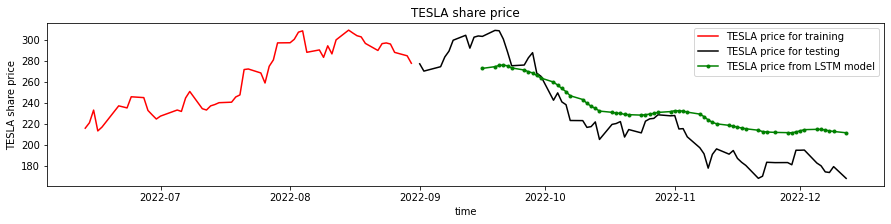

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 3))
plt.plot(train_data['Date'], train_data['Close'], color='red', label=f"TESLA price for training")
plt.plot(test_data['Date'], test_data['Close'], color='black', label=f"TESLA price for testing")
plt.plot(test_data.head(predicted_prices.shape[0])['Date'], 
         predicted_prices, 
         color= 'green', 
         label=f"TESLA price from LSTM model",
         marker='.')
plt.title(f"TESLA share price")
plt.xlabel("time")
plt.ylabel(f"TESLA share price")
plt.legend()
plt.show()

In [ ]:
# what is the LSTM and ARIMA's RMSE?